# Using `freqtools`

## Importing the module

In [2]:
%matplotlib inline

import freqtools as ft

To get more information about the provided classes and functions use `?`, e.g.

In [2]:
ft.OscillatorNoise?

or

In [3]:
ft.io.import_csv?

# Examples

For the imports of the example files, we use [pandas](https://pandas.pydata.org/), which we assume to be imported:

In [4]:
import pandas as pd

### Counter data and frequency noise

In this example we are importing counter measurements of a beatnote of two free running lasers and extracting the corresponding frequency noise. Due to the limited internal buffer we took three separate measurements of durations between 1 and 100 seconds and thus varying sample rates.

First, we import the data into `CounterData` objects.

In [4]:
files = ['counter_example_1s.json', 'counter_example_10s.json', 'counter_example_100s.json']
counter_data_list = [ft.import_json(file, as_class=ft.CounterData, silent=True) for file in files]

Each of the CounterData objects in `counter_data_list` is then converted to a `OscillatorNoise` object by using Welch's method and join them all together into one `OscillatorNoise` object:

In [5]:
noise_list = [counter_data.to_oscillator_noise() for counter_data in counter_data_list]
noise = noise_list[0]
noise.join(noise_list[1:2]) #join the 2nd and 3rd counter data to the 1st one
noise.label = 'laser beatnote'


We are interestd in the Frequency noise of one laser, so we have to divide the PSD by 2 (assuming uncorrelated noise). Changing the `values` property will automatically cause all representations to be recalculated.

In [6]:
noise.values = noise.values / 2

For linewidth calculation, we create a `BetaLine` object. By manually tweaking the coefficient, we find a model of flicker frequency noise using the `PowerLawNoise` class: 

In [7]:
beta_line = ft.BetaLine()
flicker_noise = ft.PowerLawNoise(coeff=1.5e10, exponent=-1, base='freq', representation='psd_freq')

c:\users\bastian\documents\programming\freqtools\freqtools\freq_models.py:310: RuntimeWarning: divide by zero encountered in power
  return self.coeff * freqs**self.exponent
c:\users\bastian\documents\programming\freqtools\freqtools\freq_models.py:162: RuntimeWarning: invalid value encountered in multiply
  return np.array(freqs) * self.asd_phase(freqs)


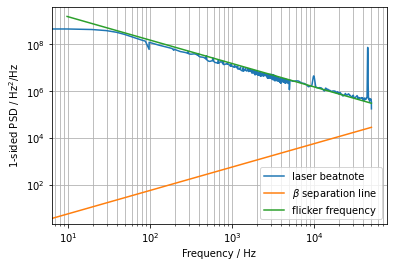

In [8]:
fig, ax = noise.plot()
beta_line.plot(noise.freqs, ax=ax)
flicker_noise.plot(noise.freqs, ax=ax)
ax.legend()

As can be seen from the plot, the data does not intersect with the $\beta$ separation line. One approach would be to use the flicker frequency noise model to create an `OscillatorNoise` object with `OsscillatorNoise(some_freqs, flicker_noise.values(some_freqs))` with appropriate frequencies `some_freqs` and calculate the linewidth with that (or use the `join` method of `OscillatorNoise` to extend the data with the model).

By default, the data is extrapolated as the last data point, i.e. assuming we reach a white frequency noise floor beyond data. With this, we determine an upper bound for the linewidth, using the $\beta$ separation line:

In [9]:
beta_line.linewidth(noise) / 1e6

0.7365025765587632

This means, an linewidth of roughly 700 kHz at 1 ms (the default value for `linewidth`).

### Spectrum analyzer data

Here, we analyze the data of a phaselock between two ECDLs.

First, we have a look a beatnote measured with a spectrum analyzer

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Frequency / Hz', ylabel='level / dBm'>)

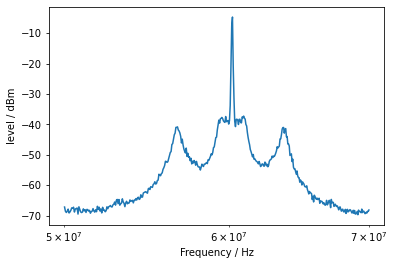

In [5]:
spec_data = pd.read_csv('laser_spectrum_analyzer_data.txt', names=["Frequency", "Amplitude"], skiprows=1, delimiter='\t')

spectrum = ft.SpectrumAnalyzerData(spec_data["Frequency"].values, spec_data["Amplitude"].values, rbw=3e5)
spectrum.plot()

We can also convert this data to phase noise (in a `OscillatorNoise` object) and plot the resulting PSD of the phase:

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Frequency / Hz', ylabel='L(f) / dBc/Hz'>)

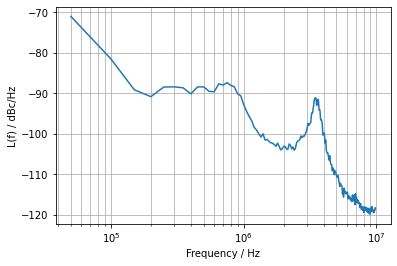

In [6]:
laser_noise_from_spec = spectrum.to_oscillator_noise()
laser_noise_from_spec.plot()

### Phase noise 

Alternatively, we record the data with a Microsemi 512 A phase noise test setup which gives much more accuarate data for frequencies closer to the carrier, however has a small frequency span of only 1 MHz

In [8]:
laser_noise_data = pd.read_csv("laser_phase_noise.csv", names=["Frequency", "Amplitude"], skiprows=1)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Frequency / Hz', ylabel='L(f) / dBc/Hz'>)

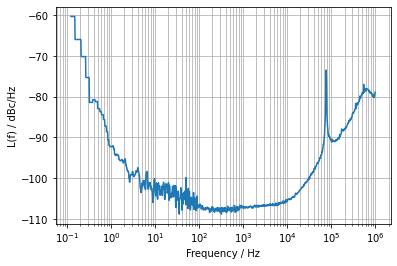

In [11]:
laser_noise = ft.OscillatorNoise(laser_noise_data["Frequency"].values,
                            laser_noise_data["Amplitude"].values,
                            representation="script_L",
                            label="Laser")
laser_noise.plot()

We now use the data from the spectrum analyzer measurement from before and manually adjust the level. We only use the data beyond one Mhz.

In [13]:
# only use these data outside of range of Microsemi tool
laser_noise_from_spec = laser_noise_from_spec[laser_noise_from_spec.freqs > 1e6] 
laser_noise_from_spec.values += 14 # manually addition to fit levels of microsemi and spectrum analyzer
laser_noise.join(laser_noise_from_spec)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x29b7cafa648>)

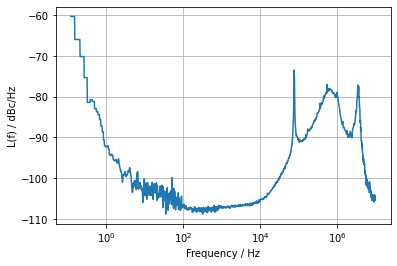

In [14]:
laser_noise.plot()

### Calculating impact of laser and quartz phase noise on atom interferometer phase noise

In this example we use the laser phase noise data from above to calculate the impact of the laser's phase noise for a Mach Zehnder atom interferometer with an interferometer time 2 T = 400 ms and a pulse time 𝜏 = 20 μs. For this we first have to consider another noise source coming from the reference quartz the experiment is disciplined to. We load the data (accounting for the division factor, noise was measured at 10 MHz, the actual frequency is 6.8 GHz) and plot it together with the phase noise form the laser.

In [12]:
quartz_noise_data = pd.read_csv("quartz_phase_noise.csv", names=["Frequency", "Amplitude"])

In [13]:
quartz_noise = ft.OscillatorNoise(quartz_noise_data["Frequency"].values,
                            quartz_noise_data["Amplitude"].values,
                            representation="script_L",
                            divide_by=680,
                            label="Quartz")

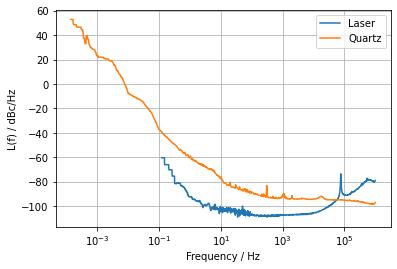

In [14]:
fig, ax = laser_noise.plot()
quartz_noise.plot(ax=ax)
ax.legend()

Next, we have to consider the transfer function of the atom interferometer. It is a highly oscillatory function with a low-pass behaviour which an be verified by calling its `plot_magnitude` method. Here we scale the transfer function with $(k_\text{eff} T^2)$ with $k_\text{eff} = \frac{4\pi}{780\,\mathrm{nm}}$ to get it in units of m/s²/rad.

In [15]:
mz_tf = ft.MachZehnderTransferFunction(T=200e-3, tau=40e-6, convert_to_g=True)

To calculate the atom interferometer noise, we first have to scale the phase noise with the squared magnitude of the transfer function and integrate over all frequencies of interest:

\begin{equation}
\sigma_{\text{AI}}^2 = \int_{f_0}^\infty |H_\text{AI}(2\pi f)|^2 \cdot S_\phi(f) \mathrm{d}f
\end{equation}

We leave the lower integration bound $f_0$ as a free parameter in this equation and inegrate all phasenoies above this frequency, or conversly, up to a certain measurement time. $S_\phi$ here is the 1-sided PSD of phase. To conversion from $L(f)$ to $S_\phi$ is done automatically, as can be seen by looking at the `representation` argument of the scaled phase noise or the plot label. 

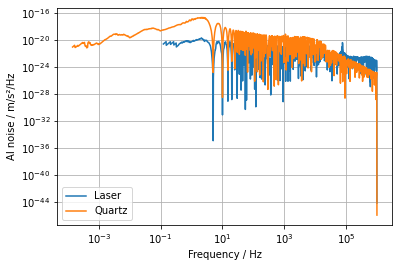

In [16]:
laser_noise_scaled = mz_tf.scale_noise(laser_noise)
quartz_noise_scaled = mz_tf.scale_noise(quartz_noise)

fig, ax = laser_noise_scaled.plot()
quartz_noise_scaled.plot(ax=ax)
ax.legend()

The last step now is the integration over all relevant frequencies. In this plot integration takes place from the right sight and for each frequency the accumulated phase noise of all higher frequencies is displayed.

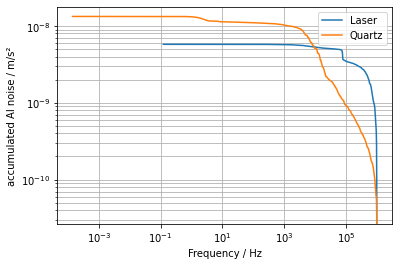

In [17]:
laser_noise_accum = laser_noise_scaled.accumulate()
quartz_noise_accum = quartz_noise_scaled.accumulate()

fig, ax = laser_noise_accum.plot()
quartz_noise_accum.plot(ax=ax)
ax.legend()